In [1]:
max_words = 2000
max_len = 40
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [2]:
import pandas as pd

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


### Предобработка

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')

# функция для удаления ненужных символов
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # удаляем упоминания пользователей
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text) # удаляем ссылки
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # удаляем все, кроме букв и цифр
    return text

# функция для токенизации и удаления стоп-слов
def preprocess_text(text):
    text = clean_text(text.lower())
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

# применяем предобработку к обучающим данным
df_train['tweet'] = df_train['tweet'].apply(preprocess_text)

# применяем предобработку к тестовым данным
df_test['tweet'] = df_test['tweet'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vmakh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_train['tweet'].head()

0    father dysfunctional selfish drags kids dysfun...
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: tweet, dtype: object

In [8]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [9]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vmakh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
tokens_filtered = [word for word in tokens if word.isalnum()]
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [11]:
tokens_filtered_top[10:]
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [12]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [13]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]], dtype=np.int32)

In [14]:
x_train.shape

(31962, 40)

In [15]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   95,   18,  331,  519,   21, 1374])

In [16]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [17]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [18]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [21]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = DataWrapper(x_test, df_test['label'].values)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/10
Step 0: loss=0.9081712365150452
Train epoch 2/10
Step 0: loss=0.12539368867874146
Train epoch 3/10
Step 0: loss=0.07317684590816498
Train epoch 4/10
Step 0: loss=0.04047522693872452
Train epoch 5/10
Step 0: loss=0.0346423014998436
Train epoch 6/10
Step 0: loss=0.017977459356188774
Train epoch 7/10
Step 0: loss=0.009297455660998821
Train epoch 8/10
Step 0: loss=0.01334747951477766
Train epoch 9/10
Step 0: loss=0.02001524530351162
Train epoch 10/10
Step 0: loss=0.017678484320640564


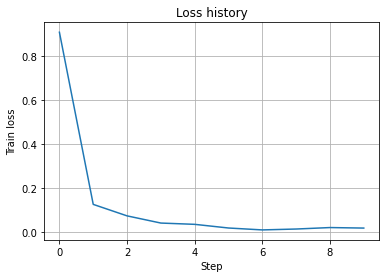

In [22]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [25]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [24]:
model.eval()


with torch.no_grad():
    
    correct = 0
    total = 0
    total_loss = 0
    
   
    for inputs, labels in test_loader:
       
        outputs = model(inputs)
        
       
        loss = loss_function(outputs, labels)
        total_loss += loss.item()
        
        
        _, predicted = torch.max(outputs.data, 1)
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    
    accuracy = 100 * correct / total
    average_loss = total_loss / len(test_loader)
    
    
    print('Accuracy on test set: {:.2f}%'.format(accuracy))
    print('Average loss on test set: {:.4f}'.format(average_loss))


AttributeError: 'DataWrapper' object has no attribute 'target'

In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Загрузка предобработанных данных
df_train = pd.read_csv('train_preprocessed.csv')

# Создание матрицы признаков и вектора целевой переменной
X = df_train['tweet'].values
y = df_train['label'].values

# Разделение данных на обучающую и валидационную выборки
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование текстовых данных в числовые
vocab_size = 2000
max_len = 40

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_X)

train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

train_X = pad_sequences(train_X, maxlen=max_len)
val_X = pad_sequences(val_X, maxlen=max_len)

# Создание DataLoader
train_data = TensorDataset(torch.tensor(train_X), torch.tensor(train_y))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [13]:
df_train['tweet'].head()

0    father dysfunctional selfish drags kids dysfun...
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: tweet, dtype: object

In [7]:
!pip install torchtext

  Using cached torchtext-0.15.1-cp39-cp39-win_amd64.whl (1.9 MB)
  Using cached torchdata-0.6.0-cp39-cp39-win_amd64.whl (1.3 MB)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Загружаем стоп-слова
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# задаем параметры токенизации
max_words = 2000
max_len = 40

# создаем токенизатор и обучаем его на обучающих данных
def tokenizer(text):
    # токенизируем текст
    tokens = word_tokenize(text.lower())
    # удаляем стоп-слова
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

word_counter = {}
for tweet in df_train['tweet']:
    for word in tokenizer(tweet):
        if word not in word_counter:
            word_counter[word] = 1
        else:
            word_counter[word] += 1

tokenizer = {word: i for i, word in enumerate(sorted(word_counter, key=word_counter.get, reverse=True)[:max_words])}

# создаем класс для набора данных
class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        tokenized_tweet = tokenizer(tweet)
        tokenized_tweet = tokenized_tweet[:self.max_len]
        padded_tweet = torch.zeros(self.max_len, dtype=torch.long)
        for i, token in enumerate(tokenized_tweet):
            if token in self.tokenizer:
                padded_tweet[i] = self.tokenizer[token]
        return padded_tweet, label

# создаем наборы данных и загрузчики
train_dataset = TwitterDataset(df_train['tweet'], df_train['label'], tokenizer, max_len)
test_dataset = TwitterDataset(df_test['tweet'], df_test['label'], tokenizer, max_len)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# создаем модель нейронной сети
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.functional.sigmoid(x)
        return x

# задаем параметры модели
vocab_size = len(tokenizer)
embedding_dim = 100
hidden_dim = 64
num_classes = 1

# создаем экземпляр модели
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, num_classes)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vmakh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyError: 'label'